In [1]:
ls

 Volume in drive C has no label.
 Volume Serial Number is 24B1-739C

 Directory of C:\Users\KrishKabra\Documents\CS269-LipReading

12/24/2020  09:47 PM    <DIR>          .
12/24/2020  09:47 PM    <DIR>          ..
12/24/2020  04:33 AM    <DIR>          .ipynb_checkpoints
12/24/2020  09:43 PM    <DIR>          .vs
12/24/2020  11:28 AM    <DIR>          __pycache__
12/12/2020  03:19 PM    <DIR>          amit
12/24/2020  09:43 PM    <DIR>          checkpoints
12/21/2020  07:38 AM    <DIR>          data
12/24/2020  11:28 AM             4,680 dataset.py
12/06/2020  09:29 PM             9,436 dlib_facial_features.ipynb
12/24/2020  07:54 PM    <DIR>          figures
12/04/2020  07:29 PM        44,086,856 keypoint_model.pkl.gz
12/08/2020  03:29 PM             2,756 KLT_makeVideo.m
12/24/2020  09:47 PM            53,606 main.ipynb
12/23/2020  06:18 AM             5,303 model.py
12/24/2020  11:06 AM             8,590 preprocess.ipynb
12/24/2020  04:35 AM             7,462 preprocess.py
12/09/202

In [2]:
from model import * 
from utils import * 
from dataset import *
from train import *

import os
import glob
import argparse
from tqdm import tqdm
from datetime import datetime

import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision

## Lip net

In [3]:
import wandb

wandb.init(project="cs269-lipreading", 
       config = {
       "model": 'LipNet-LRW',
       "dataset_path": './data/lipread_20_mp4/',
       "feature_method": 'dlib', 
       # "pretrained_weights": ,
       "checkpoint_dir": './checkpoints/',
       #"feature_size": 68*2,
       #"hidden_size": 512,
       #"num_layers": 2,
       "epochs": 100,
       "batch_size": 64,
       "n_workers": 1,
       "dropout_p": 0.5, 
       "weight_decay": 1e-6, 
       "learning_rate": 1e-4,
    })

options = wandb.config

wandb: Currently logged in as: krishk97 (use `wandb login --relogin` to force relogin)


In [4]:
print('Setting up dataloaders...')
train_set = LRWDataset_LipNet(options["dataset_path"],'train',options['feature_method'])
train_generator = DataLoader(train_set, batch_size=options["batch_size"], shuffle=True, num_workers=options["n_workers"])

# Vocab dictionaries 
vocab2int = train_set.vocab2int
int2vocab = []
vocab_size = 0
for key in vocab2int.keys(): 
    int2vocab.append(key) 
    vocab_size += 1

val_set = LRWDataset_LipNet(options["dataset_path"],'val', options['feature_method'], vocab2int=vocab2int)
val_generator = DataLoader(val_set, batch_size=options["batch_size"], num_workers=options["n_workers"])

test_set = LRWDataset_LipNet(options["dataset_path"],'test', options['feature_method'], vocab2int=vocab2int)
test_generator = DataLoader(test_set, batch_size=options["batch_size"], num_workers=options["n_workers"])

print('Dataloaders ready!')

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')
print(f'Using {device}')

# Instantiate Model
model = LipNet_LRW(vocab_size, options['dropout_p'])

model = model.to(device) # Assign CPU or GPU if available
    
# Instantiate loss function and optimizer 
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=options['learning_rate'], weight_decay=options['weight_decay'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# Start training! 
print('Starting training...')
history = train_LipNet(device, model, train_generator, val_generator, criterion, optimizer, scheduler, options)
print('Training complete!')

wandb.save("LipNet_LRW_v1.h5")

# Testing! 
test_acc, predictions, targets = evaluate_LipNet(device, model, test_generator)
print(f'Testing accuracy: {test_acc}')

Setting up dataloaders...
Dataloaders ready!
Using cuda:0
Starting training...


Epoch 0/100
------------------------------
Epoch: 0/100, Iteration: 0
Train Loss: 3.1325318813323975, Train Accuracy: 3.125
Epoch: 0/100, Iteration: 100
Train Loss: 3.1569716930389404, Train Accuracy: 3.125
Epoch: 0/100, Iteration: 200
Train Loss: 3.123248338699341, Train Accuracy: 4.6875
Epoch: 0/100, Iteration: 300
Train Loss: 3.0691232681274414, Train Accuracy: 7.8125
End of epoch: 0/100
Train Loss: 3.074320755630243, Val Loss: 2.9830907732248306
Train Accuracy: 5.184426229508197, Val Accuracy: 6.640625
Checkpoint saved at ./checkpoints/LipNet-LRW_EndOfEpoch_0_21_50_43_24_12_2020.pt
Epoch 1/100
------------------------------
Epoch: 1/100, Iteration: 0
Train Loss: 3.0861692428588867, Train Accuracy: 4.6875
Epoch: 1/100, Iteration: 100
Train Loss: 3.0894856452941895, Train Accuracy: 6.25
Epoch: 1/100, Iteration: 200
Train Loss: 3.0276384353637695, Train Accuracy: 7.8125
Epoch: 1/100, Iteration: 300
Train Loss: 3.045560836791992, Train Accuracy: 4.6875
End of epoch: 1/100
Train Loss: 3

Epoch: 15/100, Iteration: 300
Train Loss: 2.690523147583008, Train Accuracy: 15.625
End of epoch: 15/100
Train Loss: 2.7274177684158576, Val Loss: 2.5605655312538147
Train Accuracy: 15.184426229508198, Val Accuracy: 21.0546875
Checkpoint saved at ./checkpoints/LipNet-LRW_EndOfEpoch_15_22_18_26_24_12_2020.pt
Epoch 16/100
------------------------------
Epoch: 16/100, Iteration: 0
Train Loss: 2.7476606369018555, Train Accuracy: 10.9375
Epoch: 16/100, Iteration: 100
Train Loss: 2.5171685218811035, Train Accuracy: 23.4375
Epoch: 16/100, Iteration: 200
Train Loss: 2.3539886474609375, Train Accuracy: 32.8125
Epoch: 16/100, Iteration: 300
Train Loss: 2.429710865020752, Train Accuracy: 23.4375
End of epoch: 16/100
Train Loss: 2.5700668772713082, Val Loss: 2.334852881729603
Train Accuracy: 19.139344262295083, Val Accuracy: 25.41015625
Epoch 17/100
------------------------------
Epoch: 17/100, Iteration: 0
Train Loss: 2.4411423206329346, Train Accuracy: 26.5625
Epoch: 17/100, Iteration: 100
Train

Epoch: 31/100, Iteration: 0
Train Loss: 0.881253182888031, Train Accuracy: 73.4375
Epoch: 31/100, Iteration: 100
Train Loss: 0.9637655019760132, Train Accuracy: 68.75
Epoch: 31/100, Iteration: 200
Train Loss: 0.9951208829879761, Train Accuracy: 70.3125
Epoch: 31/100, Iteration: 300
Train Loss: 0.7368320822715759, Train Accuracy: 75.0
End of epoch: 31/100
Train Loss: 0.8742204642686687, Val Loss: 0.7408732157200575
Train Accuracy: 72.7202868852459, Val Accuracy: 76.62109375
Epoch 32/100
------------------------------
Epoch: 32/100, Iteration: 0
Train Loss: 0.8100614547729492, Train Accuracy: 76.5625
Epoch: 32/100, Iteration: 100
Train Loss: 0.6986590027809143, Train Accuracy: 78.125
Epoch: 32/100, Iteration: 200
Train Loss: 0.822441577911377, Train Accuracy: 71.875
Epoch: 32/100, Iteration: 300
Train Loss: 0.5482760667800903, Train Accuracy: 82.8125
End of epoch: 32/100
Train Loss: 0.8108240690387664, Val Loss: 0.7149696350097656
Train Accuracy: 74.92827868852459, Val Accuracy: 78.84765

Epoch: 46/100, Iteration: 200
Train Loss: 0.3647918701171875, Train Accuracy: 89.0625
Epoch: 46/100, Iteration: 300
Train Loss: 0.3383163511753082, Train Accuracy: 90.625
End of epoch: 46/100
Train Loss: 0.4393176601558435, Val Loss: 0.524668606929481
Train Accuracy: 86.09118852459017, Val Accuracy: 85.83984375
Epoch 47/100
------------------------------
Epoch: 47/100, Iteration: 0
Train Loss: 0.23746608197689056, Train Accuracy: 92.1875
Epoch: 47/100, Iteration: 100
Train Loss: 0.3400513529777527, Train Accuracy: 89.0625
Epoch: 47/100, Iteration: 200
Train Loss: 0.3053794503211975, Train Accuracy: 92.1875
Epoch: 47/100, Iteration: 300
Train Loss: 0.3640535771846771, Train Accuracy: 90.625
End of epoch: 47/100
Train Loss: 0.416193777664763, Val Loss: 0.4509539511054754
Train Accuracy: 86.84426229508196, Val Accuracy: 86.4453125
Epoch 48/100
------------------------------
Epoch: 48/100, Iteration: 0
Train Loss: 0.37249860167503357, Train Accuracy: 89.0625
Epoch: 48/100, Iteration: 100
T

Epoch: 61/100, Iteration: 300
Train Loss: 0.11296167224645615, Train Accuracy: 96.875
End of epoch: 61/100
Train Loss: 0.2638072443545842, Val Loss: 0.4029458216391504
Train Accuracy: 91.5061475409836, Val Accuracy: 88.65234375
Epoch 62/100
------------------------------
Epoch: 62/100, Iteration: 0
Train Loss: 0.2690119743347168, Train Accuracy: 87.5
Epoch: 62/100, Iteration: 100
Train Loss: 0.1481369435787201, Train Accuracy: 93.75
Epoch: 62/100, Iteration: 200
Train Loss: 0.3088866174221039, Train Accuracy: 90.625
Epoch: 62/100, Iteration: 300
Train Loss: 0.2187991738319397, Train Accuracy: 90.625
End of epoch: 62/100
Train Loss: 0.2614945811570668, Val Loss: 0.3765860772691667
Train Accuracy: 91.64959016393442, Val Accuracy: 90.3125
Epoch 63/100
------------------------------
Epoch: 63/100, Iteration: 0
Train Loss: 0.2271985560655594, Train Accuracy: 93.75
Epoch: 63/100, Iteration: 100
Train Loss: 0.22608105838298798, Train Accuracy: 92.1875
Epoch: 63/100, Iteration: 200
Train Loss:

End of epoch: 76/100
Train Loss: 0.17014424601783518, Val Loss: 0.3559842153917998
Train Accuracy: 94.5235655737705, Val Accuracy: 90.80078125
Epoch 77/100
------------------------------
Epoch: 77/100, Iteration: 0
Train Loss: 0.25034740567207336, Train Accuracy: 92.1875
Epoch: 77/100, Iteration: 100
Train Loss: 0.10131480544805527, Train Accuracy: 96.875
Epoch: 77/100, Iteration: 200
Train Loss: 0.19536356627941132, Train Accuracy: 95.3125
Epoch: 77/100, Iteration: 300
Train Loss: 0.21981605887413025, Train Accuracy: 93.75
End of epoch: 77/100
Train Loss: 0.16730009476180938, Val Loss: 0.35636505810543895
Train Accuracy: 94.62602459016394, Val Accuracy: 90.41015625
Epoch 78/100
------------------------------
Epoch: 78/100, Iteration: 0
Train Loss: 0.22372978925704956, Train Accuracy: 92.1875
Epoch: 78/100, Iteration: 100
Train Loss: 0.08573377132415771, Train Accuracy: 98.4375
Epoch: 78/100, Iteration: 200
Train Loss: 0.16670896112918854, Train Accuracy: 95.3125
Epoch: 78/100, Iterati

End of epoch: 91/100
Train Loss: 0.1558026791473881, Val Loss: 0.3560316991060972
Train Accuracy: 95.13319672131148, Val Accuracy: 90.80078125
Epoch 92/100
------------------------------
Epoch: 92/100, Iteration: 0
Train Loss: 0.07558073848485947, Train Accuracy: 98.4375
Epoch: 92/100, Iteration: 100
Train Loss: 0.19550511240959167, Train Accuracy: 93.75
Epoch: 92/100, Iteration: 200
Train Loss: 0.1659603863954544, Train Accuracy: 93.75
Epoch: 92/100, Iteration: 300
Train Loss: 0.21559321880340576, Train Accuracy: 90.625
End of epoch: 92/100
Train Loss: 0.15970271081953752, Val Loss: 0.35548233590088785
Train Accuracy: 94.93852459016394, Val Accuracy: 90.80078125
Epoch 93/100
------------------------------
Epoch: 93/100, Iteration: 0
Train Loss: 0.2236061692237854, Train Accuracy: 92.1875
Epoch: 93/100, Iteration: 100
Train Loss: 0.1568002849817276, Train Accuracy: 92.1875
Epoch: 93/100, Iteration: 200
Train Loss: 0.1930789202451706, Train Accuracy: 93.75
Epoch: 93/100, Iteration: 300


## Feature net

In [5]:
# import wandb

# wandb.init(project="cs269-lipreading", 
#        config = {
#        "model": 'BiLSTM-LRW',
#        "dataset_path": './data/lipread_20_mp4/',
#        "feature_method": 'dlib', 
#        # "pretrained_weights": ,
#        "checkpoint_dir": './checkpoints/',
#        "feature_size": 68*2,
#        "hidden_size": 512,
#        "num_layers": 2,
#        "epochs": 100,
#        "batch_size": 128,
#        "n_workers": 1,
#        "dropout_p": 0.25, 
#        "weight_decay": 1e-6, 
#        "learning_rate": 1e-4,
#     })

# options = wandb.config

In [6]:
# print('Setting up dataloaders...')
# train_set = LRWDataset_features(options["dataset_path"],'train',options['feature_method'])
# train_generator = DataLoader(train_set, batch_size=options["batch_size"], shuffle=True, num_workers=options["n_workers"])

# # Vocab dictionaries 
# vocab2int = train_set.vocab2int
# int2vocab = []
# vocab_size = 0
# for key in vocab2int.keys(): 
#     int2vocab.append(key) 
#     vocab_size += 1

# val_set = LRWDataset_features(options["dataset_path"],'val', options['feature_method'], vocab2int=vocab2int)
# val_generator = DataLoader(val_set, batch_size=options["batch_size"], num_workers=options["n_workers"])

# test_set = LRWDataset_features(options["dataset_path"],'test', options['feature_method'], vocab2int=vocab2int)
# test_generator = DataLoader(test_set, batch_size=options["batch_size"], num_workers=options["n_workers"])

# print('Dataloaders ready!')

# # train on the GPU or on the CPU, if a GPU is not available
# device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
# # device = torch.device('cpu')
# print(f'Using {device}')

# # Instantiate Model
# model = BiLSTM_LRW(options['feature_size'], 
#                      vocab_size, options['hidden_size'], 
#                      options['num_layers'], 
#                      options['dropout_p'])
# model = model.to(device) # Assign CPU or GPU if available
    
# # Instantiate loss function and optimizer 
# criterion = nn.CrossEntropyLoss().to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=options['learning_rate'], weight_decay=options["weight_decay"])
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# # Start training! 
# print('Starting training...')
# history = train_features_model(device, model, train_generator, val_generator, criterion, optimizer, scheduler, options)
# print('Training complete!')

# wandb.save("BiLSTM_LRW.h5")

# # Testing! 
# test_acc, predictions, targets = evaluate_features_model(device, model, test_generator)
# print(f'Testing accuracy: {test_acc}')

## Plotting

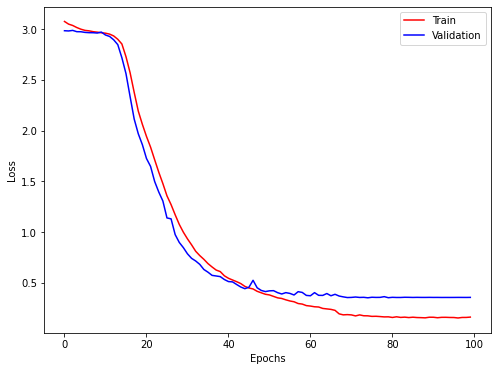

<AxesSubplot:>

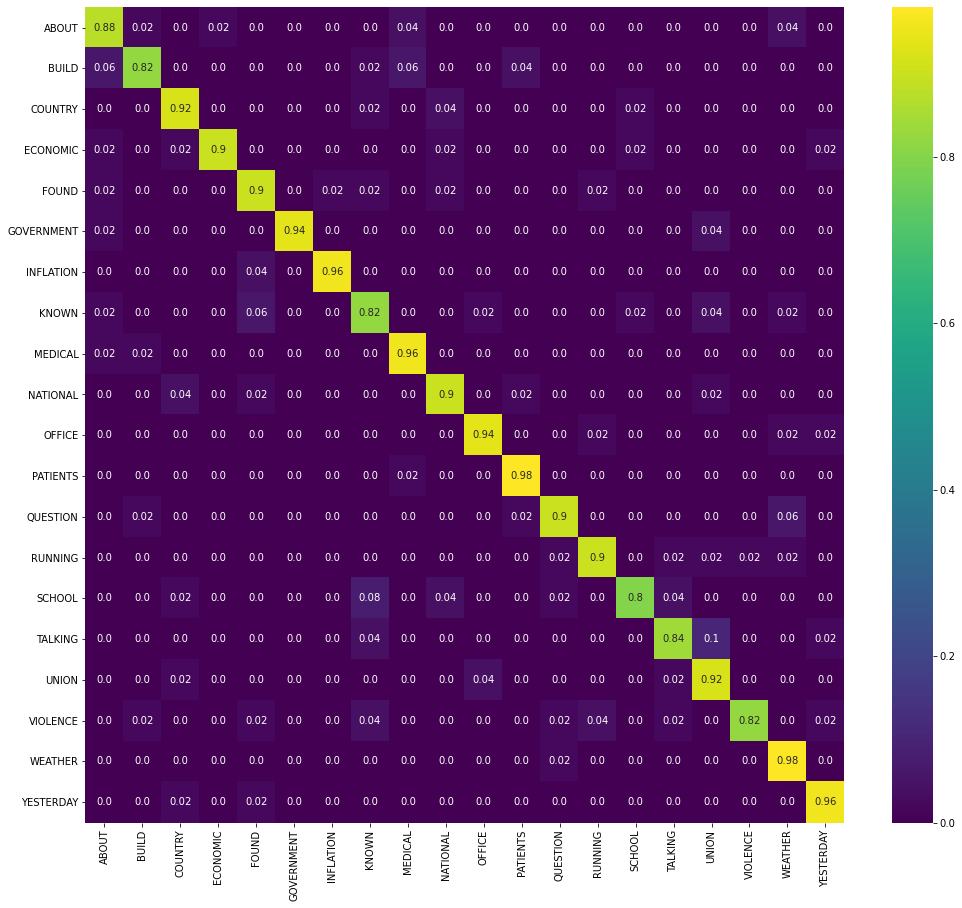

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Testing! 
# test_acc, predictions, targets = evaluate_features_model(device, model, test_generator)
# print(f'Testing accuracy: {test_acc}')

predictions = [int2vocab[pred] for pred in predictions]
targets = [int2vocab[target] for target in targets]

labels = [key for key in vocab2int.keys()]
train_loss = np.array(history['train_loss'])
val_loss = np.array(history['val_loss'])

# Plot loss
plt.figure(figsize=(8,6))
plt.plot(np.arange(train_loss.shape[0]),train_loss,color='r')
plt.plot(np.arange(val_loss.shape[0]),val_loss,color='b')
plt.legend(['Train', 'Validation'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Confusion matrix 
cf_matrix = confusion_matrix(targets, predictions, labels=labels, normalize='true')
fig, ax = plt.subplots(figsize=[17,15])
sns.heatmap(cf_matrix, cmap="viridis", annot=True, fmt='.2',
            xticklabels=labels, yticklabels=labels, ax=ax)